# Introducción a Keras y TensorFlow

TensorFlow (TF) es una plataforma basada en Python, gratuita y de código abierto, desarrollada principalmente por Google. Similar a NumPy, el propósito principal de TensorFlow es permitir al usuario manipular expresiones matemáticas en tensores numéricos.

Keras es una API (Application Programming Interface) para Python, construida sobre TensorFlow, que provee una manera conveniente para definir y entrenar cualquier tipo de modelo de DL. 

## Tensores constantes y variables

Para hacer algo en TF, necesitamos algunos tensores. Los tensores deben crearse con algún valor inicial. Por ejemplo, podríamos crear tensores que sólo contengan unos o ceros, o tensores que tengan valores de alguna distribución aleatoria.

In [15]:
import tensorflow as tf
import numpy as np

a = tf.ones(shape = (2,1))  # Equivalente a np.ones(shape=(2,1))

print(a)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


In [2]:
b = tf.zeros(shape = (3,3)) # Equivalente a np.zeros(shape=(2,1))

print(b)

tf.Tensor(
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]], shape=(3, 3), dtype=float32)


In [3]:
# Creamos un tensor con valores aleatorios a partir de una distribución
# normal con media = 0 y desviación estándar = 1

c = tf.random.normal(shape = (3,1), mean = 0.0, stddev = 1.0)

print(c)

tf.Tensor(
[[ 0.66024625]
 [ 0.13119078]
 [-1.3691951 ]], shape=(3, 1), dtype=float32)


In [4]:
d = tf.random.uniform(shape = (3,1), minval = 0., maxval = 1.)

print(d)

tf.Tensor(
[[0.2655337]
 [0.5469104]
 [0.6311189]], shape=(3, 1), dtype=float32)


Para entrenar un modelo, necesitamos actualizar su estado, que es un conjunto de tensores. Como los tensores no son asignables, tenemos que utilizar *variables* con la clase `tf.Variable`, que nos permite modificar el estado en TF. 

Para crear una variable, necesitamos dar un valor inicial, como un tensor aleatorio.

In [5]:
v = tf.Variable(initial_value = tf.random.normal(shape = (3,1)))

print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 0.18516354],
       [-2.2039483 ],
       [ 0.51739603]], dtype=float32)>


El estado de la variable se puede modificar a través del método `assign`, como sigue:

In [6]:
v.assign(tf.ones((3,1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

También funciona para un subconjunto de entradas.

In [7]:
v[0,0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

### Operaciones tensoriales

TF ofrece un conjunto de operaciones tensoriales para expresar fórmulas matemáticas. Por ejemplo, si queremos obtener el cuadrado de las entradas de un tensor, usamos

In [8]:
print(d)

tf.Tensor(
[[0.2655337]
 [0.5469104]
 [0.6311189]], shape=(3, 1), dtype=float32)


In [9]:
d_sq = tf.square(d)

d_sq

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.07050814],
       [0.29911098],
       [0.39831105]], dtype=float32)>

Para sacar la raíz cuadrada

In [10]:
d_sqrt = tf.sqrt(d)

d_sqrt

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.5152996],
       [0.7395339],
       [0.7944299]], dtype=float32)>

Sumamos dos tensores, entrada a entrada

In [11]:
suma = c + d

suma

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[ 0.92577994],
       [ 0.6781012 ],
       [-0.7380762 ]], dtype=float32)>

### Gradient Tape

`GradientTape` es una API que nos permite utilizar las capacidades de diferenciación automática de TF. Es un esquema de Python que va a "registrar" las operaciones tensoriales que corran dentro de él, en forma de un grafo computacional (a veces llamado *tape*). Ese grafo puede usarse para recuperar el gradiente de cualquier salida con respecto a cualquier variable o conjunto de variables (las instancias de la clase `tf.Variable`). 

Una `tf.Variable` es un tipo específico de tensor que debe mantener un estado mutable, por ejemplo, los pesos de una red neuronal siempre son instancias del tipo `tf.Variable`.

In [12]:
x = tf.Variable(0.) # Variable escalar con valor inicial de 0

with tf.GradientTape() as tape: # Iniciamos el esquema de GradientTape
    y = 2 * x + 3               # Dentro del esquema, aplicamos operaciones tensoriales a la variable

dy_dx = tape.gradient(y, x) # Utilizamos la tape para recuperar el gradiente de la salida y respecto a x

print(dy_dx)

tf.Tensor(2.0, shape=(), dtype=float32)


Veamos otro ejemplo, ahora con un tensor un poco más complejo.

In [13]:
x = tf.Variable(tf.random.uniform((2,2))) # Variable de forma (2,2) con valores iniciales todos ceros

with tf.GradientTape() as tape:
    y = 2 * x + 3

grad_of_y_wrt_x = tape.gradient(y, x)

grad_of_y_wrt_x



<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 2.],
       [2., 2.]], dtype=float32)>

## Ejemplo: Clasificador lineal en TensorFlow

Ya vimos tensores, variables y operaciones tensoriales, y ya sabemos cómo calcular gradientes. Podemos construir cualquier modelo de ML que se base en el método del gradiente descendente. Veamos.

Supongamos que nos piden implementar un clasificador lineal usando TF. Vamos a ir paso a paso, así que vamos a generar datos sintéticos bonitos y separables para trabajar: dos clases de puntos en un plano.

Generaremos cada clase de puntos dibujando sus coordenadas a partir de una distribución aleatoria con matriz de covarianza y media específicas. Recordemos que, de forma intuitiva, la matriz de covarianza describe la forma de la nube de puntos, y que la media describe su posición en el plano. 

Para este ejemplo vamos a utilizar la misma matriz de covarianza para cada una de las nubes de puntos, pero utilizaremos dos medias distintas, por lo que las nubes van a tener la misma forma, pero posiciones distintas.

Primero definiremos el número de puntos por clase que queremos, que van a ser, 1000 en cada nube.

Después, generamos las muestras "negativas" de 1000 puntos aleatorios. La matriz de covarianza coresponde a una nubecita en forma de óvalo orientada desde abajo a la izquierda hacia arriba y a la derecha.

El otro conjunto de datos es lo mismo, pero con media distinta.

In [16]:
num_samples_per_class = 1000


negative_samples = np.random.multivariate_normal(
                                                mean = [0, 3],
                                                cov = [[1, 0.5], [0.5, 1]],
                                                size = num_samples_per_class)

positive_samples = np.random.multivariate_normal(
                                                mean = [3, 0],
                                                cov = [[1, 0.5], [0.5,1]],
                                                size = num_samples_per_class)

En la celda anterior, las variables `negative_samples` y `positive_samples` son arrays de forma (1000,2). Pongamos uno sobre otro para formar un sólo array de (2000,2).

In [17]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

Ahora, tenemos que generar también las correspondientes etiquetas objetivo, que en este caso serán un array de ceros y unos de forma (2000,1), donde `targets[i,0]` va a ser 0 si `inputs[i]` pertenece a la clase 0 (y visceversa).

In [18]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype = 'float32'),
                    np.ones((num_samples_per_class, 1), dtype = 'float32')))

Grafiquemos los datos con Matplotlib.

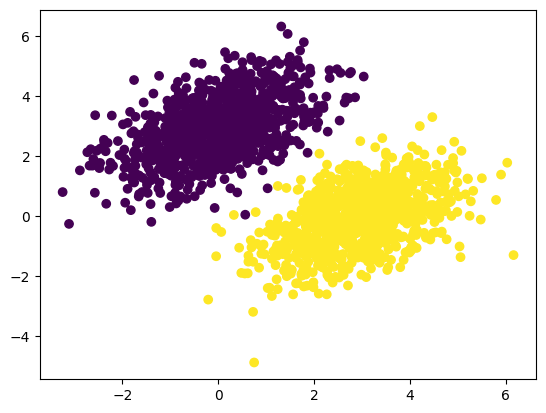

In [19]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:,0], inputs[:,1], c = targets[:,0])

plt.show()

Bien, tenemos los datos de entrada listos. Ahora crearemos un clasificador lineal que aprenda a separar estos dos aglomerados. Un clasificador lineal es una transformación afín (`predicción = W • entrada + b`) entrenado para minimizar el cuadrado de la diferencia entre las predicciones y los objetivos.

Creamos entonces nuestras variables `w` y `b`, inicializando con valores aleatorios y con ceros, respectivamente.

In [20]:
input_dim = 2 # Las entradas son puntos en 2 dimensiones

output_dim = 1 # Mientras que la salida será 0 o 1

w = tf.Variable(initial_value = tf.random.uniform(shape = (input_dim, output_dim)))

b = tf.Variable(initial_value = tf.zeros(shape = (output_dim)))


Definimos la función de paso:

In [21]:
def model(inputs):
    return tf.matmul(inputs, w) + b

Como nuestro clasificador lineal opera en entradas de 2 dimensiones, `w` en realidad está formado por dos coeficientes escalares, `w1` y `w2`: `w = [[w1], [w2]]`.

Mientras que `b` es un solo coeficiente escalar. Por lo que, para cada dato de entrada `[x,y]`, su predicción será: `prediction = [[w1]. [w2]] • [x,y] + b = w1 * x + w2 * y + b`.

Ahora, definimos la función de costo, que en este caso corresponde al error cuadrático medio.

In [22]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

`per_sample_losses` será un tensor con la misma forma que los objetivos y las predicciones y que va a contener los scores de la función de costo.

El método `tf.reduce_mean()` promedia todos los valores de la función de costo y nos da un sólo número.

Ahora sigue el paso de entrenamiento, donde se va a recibir un poco de datos de entrenamiento y se van a actualizar los pesos `w` y el valor `b` para reducir el costo sobre los datos.

In [23]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)
    grad_loss_wrt_w, grad_loss_wrt_b = tape.gradient(loss, [w,b])
    w.assign_sub(grad_loss_wrt_w * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

Por simplicidad, se hará *batch training* en vez de *mini-batch training*: vamos a correr cada paso de entrenamiento (calcular el gradiente y actualizar los pesos) para todos los datos, en vez de iterar en pequeños conjuntos del conjunto completo. 

In [24]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f'Loss at step {step}: {loss:.4f}')

Loss at step 0: 0.9926
Loss at step 1: 0.1791
Loss at step 2: 0.1137
Loss at step 3: 0.1013
Loss at step 4: 0.0940
Loss at step 5: 0.0878
Loss at step 6: 0.0821
Loss at step 7: 0.0770
Loss at step 8: 0.0723
Loss at step 9: 0.0681
Loss at step 10: 0.0642
Loss at step 11: 0.0607
Loss at step 12: 0.0575
Loss at step 13: 0.0546
Loss at step 14: 0.0519
Loss at step 15: 0.0495
Loss at step 16: 0.0474
Loss at step 17: 0.0454
Loss at step 18: 0.0435
Loss at step 19: 0.0419
Loss at step 20: 0.0404
Loss at step 21: 0.0390
Loss at step 22: 0.0378
Loss at step 23: 0.0367
Loss at step 24: 0.0356
Loss at step 25: 0.0347
Loss at step 26: 0.0338
Loss at step 27: 0.0331
Loss at step 28: 0.0324
Loss at step 29: 0.0317
Loss at step 30: 0.0311
Loss at step 31: 0.0306
Loss at step 32: 0.0301
Loss at step 33: 0.0297
Loss at step 34: 0.0293
Loss at step 35: 0.0289
Loss at step 36: 0.0286
Loss at step 37: 0.0283
Loss at step 38: 0.0280
Loss at step 39: 0.0278


Después de 40 iteraciones, el costo del entrenamiento parece estabilizarse alrededor de 0.0255. Grafiquemos cómo nuestro modelo lineal clasifica los datos de entrenamiento.

Como nuestros objetivos son ceros y unos, una entrada dada puede ser clasificada como "0", si su valor de predicción es menor a 0.5, y como "1" si está por arriba de 0.5


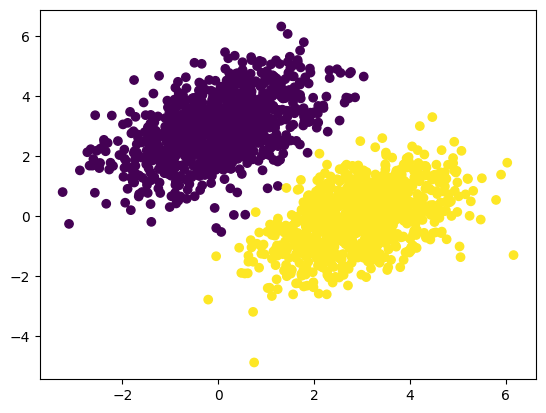

In [25]:
predictions = model(inputs)

plt.scatter(inputs[:,0], inputs[:,1], c = predictions[:,0] > 0.5)
plt.show()

Casi no se nota la diferencia entre las predicciones del modelo (gráfica de arriba) y los datos de entrada. 

Recordemos que el valor de la predicción para cualquier punto $(x,y)$ es simplemente:

$$ \hat{y} = w_1 x + w_2 y + b  $$

Y las clases a las que se clasifica la predicción son tales que:

$$ \hat{y} = \begin{cases}
            0 & \text{si} & w_1 x + w_2 y + b < 0.5 \\
            1 & \text{si} & w_1 x + w_2 y + b > 0.5 \\

\end{cases} $$

Pero pues esto equivale a la ecuación de una recta:

$$  w_1 x + w_2 y + b = 0.5 \quad \to \quad y = - \frac{w_1}{w_2} x + \frac{0.5 - b}{w_2}$$

Arriba de la línea está la clase 1 y por debajo la clase 0. 

Grafiquemos.

In [ ]:
x = np.linspace(-1, 4, 100)

y = -w[0] / w[1] * x + (0.5 - b) / w[1]

plt.plot(x,y, "-r")
plt.scatter(inputs[:,0], inputs[:,1], c = predictions[:,0] > 0.5)
plt.show()


De esto se trata la tarea de un clasificador. Encuentra los parámetros de una línea (o, en muchas dimensiones, un hiperplano) que logre separar adecuadamente dos tipos de datos.

## APIs de Keras fundamentales

### Layers: los bloques de construcción del deep learning

La estructura fundamental de datos en las redes neuronales son las *capas* (*layers*). Una capa es un módulo de procesamiento de datos que toma como entrada uno o más tensores y que produce scomo salida uno o más tensores. Algunas capas no tienen estado, pero la mayor parte del tiempo tienen un estado: los *pesos* de las capas, que son uno o varios tensores aprendidos a través del gradiente estocástico descendiente, que en conjunto contienen el *aprendizaje* de la red.



In [31]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation = None):

        super().__init__()

        self.units = units

        self.activation = activation 

    def build(self, input_shape):

        input_dim = input_shape[-1]

        self.W = self.add_weight(shape = (input_dim, self.units),
                                 initializer = "random_normal")
        
        self.b = self.add_weight(shape = (self.units,),
                                 initializer = "zeros")
        
    def call(self, inputs):

        y = tf.matmul(inputs, self.W) + self.b

        if self.activation is not None:

            y = self.activation(y)

        return y



In [32]:
my_dense = SimpleDense(units = 32, activation = tf.nn.relu)

In [33]:
input_tensor = tf.ones(shape = (2, 784))

In [34]:
output_tensor = my_dense(input_tensor)

print(output_tensor.shape)

(2, 32)
